In [36]:
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def train_team_embedding_mlp(
    df,
    label_column="Improvement?",
    team_column="Team",
    embedding_dim=12,
    test_split=0.35,
    hidden_dims=(8, 4),
    dropout_rate=0.1,
    learning_rate=0.003,
    epochs=50,
    batch_size=12
):
    """
    Trains an MLP to learn team-level embeddings from off-season data.
    Returns a DataFrame with embeddings for each team.
    """
    # Optional: Filter rows with valid labels (if supervised)
    df_filtered = df[df[label_column].isin(["Better", "Worse"])]
    y = df_filtered[label_column].map({"Better": 1, "Worse": 0}).values
    X = df_filtered.drop(columns=[label_column, team_column]).values
    teams_filtered = df_filtered[team_column].values

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_split, random_state=42)

    # Build MLP model
    input_dim = X_train.shape[1]
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(hidden_dims[0], activation='relu')(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dims[1], activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    embeddings = layers.Dense(embedding_dim, activation='linear', name='embeddings')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    embedding_model = models.Model(inputs, embeddings)

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Generate embeddings for all teams (even those not in training set)
    all_X = df.drop(columns=[label_column, team_column]).values
    all_X_scaled = scaler.transform(all_X)
    all_teams = df[team_column].values
    all_embeddings = embedding_model.predict(all_X_scaled)

    # Build output DataFrame
    emb_df = pd.DataFrame(all_embeddings, columns=[f"mlp_emb_{i}" for i in range(embedding_dim)])
    emb_df["team"] = all_teams
    emb_df.set_index("team", inplace=True)

    return emb_df, history


In [37]:
# Load your CSV
df = pd.read_csv("offseason_2024_labeled.csv")

df['Team'] = ['CRD', 'ATL', 'RAV', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
              'DEN', 'DET', 'GNB', 'HTX', 'CLT', 'JAX', 'KAN', 'RAI', 'SDG',
              'RAM', 'MIA', 'MIN', 'NWE', 'NOR', 'NYG', 'NYJ', 'PHI', 'PIT',
              'SFO', 'SEA', 'TAM', 'OTI', 'WAS'] 

In [38]:
# Call the function
mlp_embeddings, history = train_team_embedding_mlp(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [39]:
import matplotlib.pyplot as plt

def plot_training_history(history, title_prefix="MLP Embedding"):
    """
    Plots training and validation accuracy/loss from a Keras History object.
    """
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


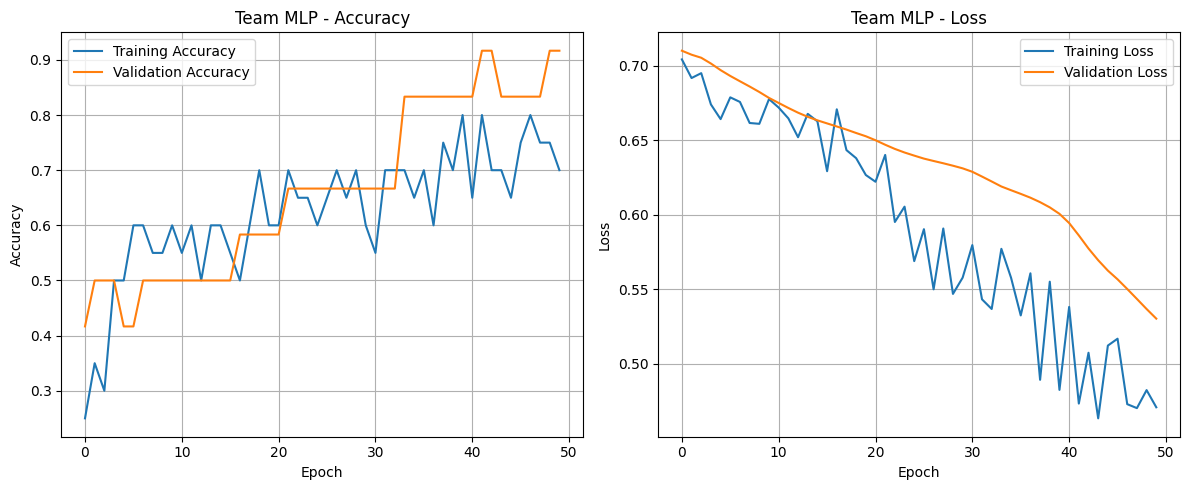

In [40]:
mlp_embeddings, history = train_team_embedding_mlp(df)
plot_training_history(history, title_prefix="Team MLP")

In [41]:
# Optionally save
mlp_embeddings.to_csv("mlp_2023_2024_embeddings.csv")

In [51]:
mlp_model.save('offseason_MLP.keras')